<a href="https://www.kaggle.com/code/ravi20076/playgrounds4e08-datastore?scriptVersionId=191003791" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **IMPORTS AND INSTALLATIONS**

In [1]:
%%capture

!pip install polars==1.2.1
!pip install -q ucimlrepo
from ucimlrepo import fetch_ucirepo 

In [2]:
%%capture

import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
from pprint import pprint
from gc import collect

from collections import Counter
from itertools import product
from colorama import Fore, Style, init
from warnings import filterwarnings

from tqdm.autonotebook import tqdm
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

filterwarnings("ignore")


In [3]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        }
       )

grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
              'color': 'lightgrey', 'linewidth': 0.75
             };

title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': '#992600'};

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string"
    print(style + color + text + Style.RESET_ALL)

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

print()
collect()


CPU times: user 125 ms, sys: 17.9 ms, total: 143 ms
Wall time: 209 ms


4

# **FOREWORD**

This kernel aims to engender the below tasks- <br>
1. Organize the train, original and test data in smaller files for easy and convenient data storage <br>
2. Develop appropriate feature engineering caveats for these datasets to directly use in my further steps <br>
3. Please find some useful discussions for this competition as below. They are incredibly informative in my opinion and act as references for the kernel-

- https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523439 <br> 
- https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523442 <br>
- https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523440 <br> 
- https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523705 <br> 

## **ORIGINAL DATA SOURCES**

I took the idea of using this dataset from the sources below- <br>
1. External Source- https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset <br> 
2. Kaggle source - https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523439 <br>

<br>Additionally, I use the supplementary dataset from the post link [here](https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523705) and append this to the existing data. I think we can consider sampling this data later based on our further requirements.

# **PREPROCESSING**

In [4]:
%%time 

version_nb   = 1
target       = "class"
visuals_req  = True
mapper       = {"e" : 0, "p" : 1}

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


## **DATA LOADING**

In [5]:
%%time 

PrintColor(f"\n{'=' * 20} DATA LOADING {'=' * 20}\n")

train  = pd.read_csv(f"/kaggle/input/playground-series-s4e8/train.csv").set_index("id")
test   = pd.read_csv(f"/kaggle/input/playground-series-s4e8/test.csv").set_index("id")
sub_fl = pd.read_csv(f"/kaggle/input/playground-series-s4e8/sample_submission.csv").set_index("id")
        
print(f"---> Loading secondary original data")
secondary_mushroom = fetch_ucirepo(id=848) 
original = \
pd.concat([pd.DataFrame(secondary_mushroom.data.features), 
           pd.DataFrame(secondary_mushroom.data.targets)
          ], axis=1)
original.index.name = "id"

print(f"---> Loading teritary original data")
orig = \
pd.read_csv(f"/kaggle/input/tertiary-mushroom-1-million-more-mushrooms/one_million_mushrooms.csv", sep = ";")

for df in [train, test, original, orig]:
    df.columns = df.columns.str.replace("-","")
    
cat_cols  = test.select_dtypes("object").columns
cont_cols = test.select_dtypes(float).columns

with np.printoptions(linewidth = 80):
    PrintColor("\n---> Category columns\n", color = Fore.RED)
    print(np.array(cat_cols))
    
PrintColor(f"\n\n---> Shapes = {train.shape} | {test.shape} | {original.shape} | {orig.shape} \n", 
           color = Fore.CYAN
          )

collect();
print();


==================== DATA LOADING ====================

---> Loading secondary original data
---> Loading teritary original data

---> Category columns

['capshape' 'capsurface' 'capcolor' 'doesbruiseorbleed' 'gillattachment'
 'gillspacing' 'gillcolor' 'stemroot' 'stemsurface' 'stemcolor' 'veiltype'
 'veilcolor' 'hasring' 'ringtype' 'sporeprintcolor' 'habitat' 'season']


---> Shapes = (3116945, 21) | (2077964, 20) | (61069, 21) | (1038000, 21) 


CPU times: user 16.7 s, sys: 5.68 s, total: 22.4 s
Wall time: 27.4 s


## **DATA PREPROCESSING**

Here, we carry out 2 steps for category columns- 
1. Replace all nulls with a new category- **missing** <br>
2. Replace noise elements in the competition dataset with a new category - **noise**

In [6]:
%%time 

PrintColor(f"\n{'=' * 20} DATA PREPROCESSING {'=' * 20}\n")

for df in [train, test, original, orig]:    
    df[cat_cols]  = df[cat_cols].fillna("missing")
    df[cont_cols] = df[cont_cols].astype(np.float32) 

print();
display(
    pd.DataFrame.from_dict(
        {"Train"    : train[cat_cols].nunique(), 
         "Test"     : test[cat_cols].nunique(),
         "Original" : original[cat_cols].nunique(),
         "Original2": orig[cat_cols].nunique(),
        }
    ).transpose().\
    style.
    set_caption(f"Unique values across category columns before preprocessing").\
    set_properties(**{"text-align": "center"})
)

for col in tqdm(cat_cols):
    unq_vals = \
    list(
        set(np.concatenate([train[col].unique(), test[col].unique()])).\
        difference(set(original[col].unique()))
    )

    train.loc[train[col].isin(unq_vals), col] = "noise"
    test.loc[test[col].isin(unq_vals), col]   = "noise"
    
print();
display(
    pd.DataFrame.from_dict(
        {"Train"    : train[cat_cols].nunique(), 
         "Test"     : test[cat_cols].nunique(),
         "Original" : original[cat_cols].nunique(),
         "Original2": orig[cat_cols].nunique(),
        }
    ).transpose().\
    style.
    set_caption(f"Unique values across category columns after preprocessing").\
    set_properties(**{"text-align": "center"})
)

df_dict = \
{"Train": train,
 "Test": test, 
 "Original": original, 
 "Original2": orig
}

print();
collect();


==================== DATA PREPROCESSING ====================




,capshape,capsurface,capcolor,doesbruiseorbleed,gillattachment,gillspacing,gillcolor,stemroot,stemsurface,stemcolor,veiltype,veilcolor,hasring,ringtype,sporeprintcolor,habitat,season
Train,75,84,79,27,79,49,64,39,61,60,23,25,24,41,33,53,4
Test,63,60,58,23,67,36,57,32,55,56,16,24,24,37,34,40,4
Original,7,12,12,2,8,4,12,6,9,13,2,7,2,9,8,8,4
Original2,7,12,12,2,8,4,12,6,9,13,2,7,2,9,8,8,4


  0%|          | 0/17 [00:00<?, ?it/s]

,capshape,capsurface,capcolor,doesbruiseorbleed,gillattachment,gillspacing,gillcolor,stemroot,stemsurface,stemcolor,veiltype,veilcolor,hasring,ringtype,sporeprintcolor,habitat,season
Train,8,13,13,3,9,5,13,7,10,14,3,8,3,10,9,9,4
Test,8,13,13,3,9,5,13,7,10,14,3,8,3,10,9,9,4
Original,7,12,12,2,8,4,12,6,9,13,2,7,2,9,8,8,4
Original2,7,12,12,2,8,4,12,6,9,13,2,7,2,9,8,8,4



CPU times: user 34.5 s, sys: 4.31 s, total: 38.8 s
Wall time: 38.8 s


## **BASELINE VISUALS**

0it [00:00, ?it/s]

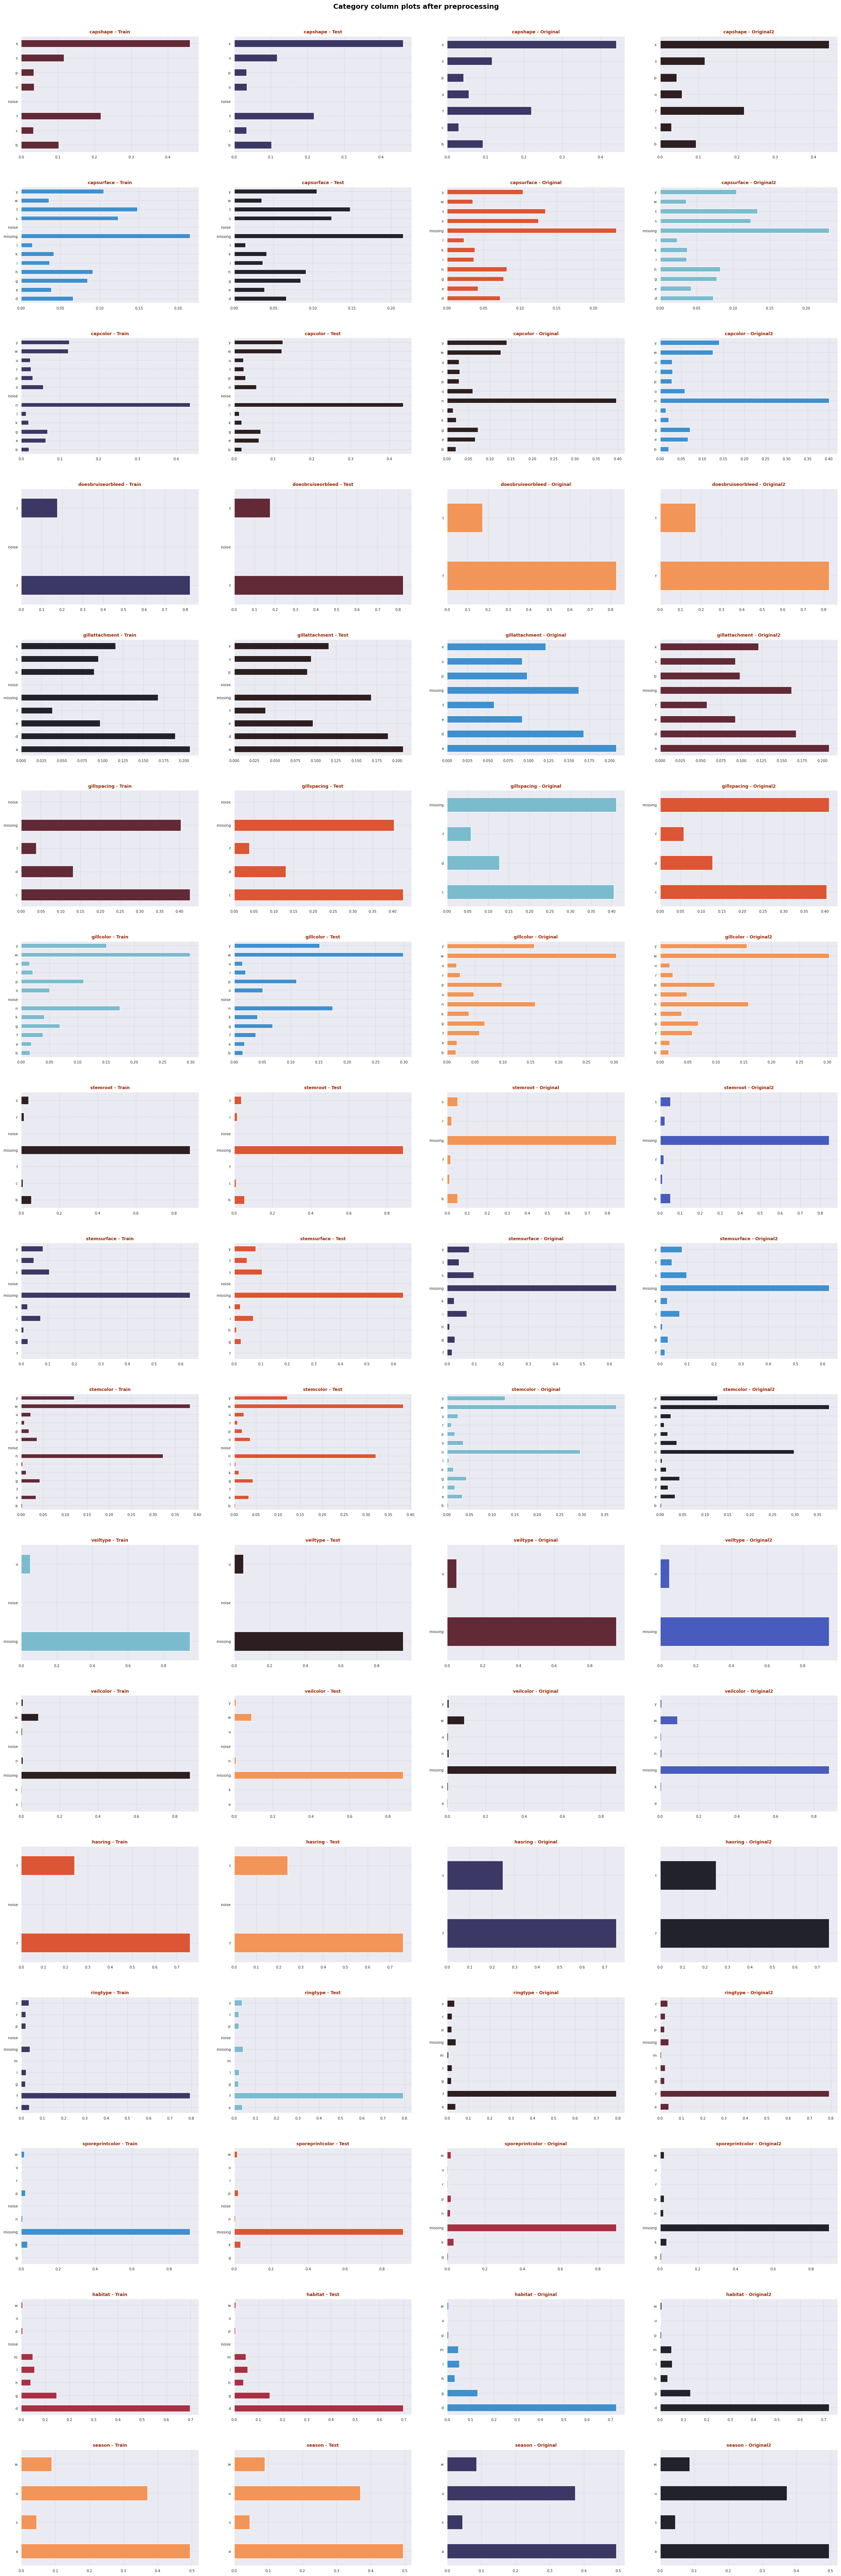


CPU times: user 25 s, sys: 469 ms, total: 25.5 s
Wall time: 25.2 s


In [7]:
%%time

if visuals_req:
    fig, axes = plt.subplots(len(cat_cols), 4, 
                             figsize = (30, 5.5 * len(cat_cols)),
                             gridspec_kw = {"hspace": 0.3, "wspace": 0.2}
                            )

    for j, col in tqdm(enumerate(cat_cols)):
        colors = sns.color_palette("icefire", n_colors = 10)

        for i, (label, df) in enumerate(df_dict.items()):
            ax = axes[j, i]
            df[col].value_counts(normalize = True).sort_index().\
            plot.barh(color = colors[np.random.randint(0, 10, 1)[0]], ax = ax)
            ax.set_title(f"{col} - {label}", **title_specs);
            ax.grid(**grid_specs);
            ax.set(ylabel = "")

    plt.tight_layout()
    plt.suptitle(f"Category column plots after preprocessing", 
                 y = 0.89, color = "black", fontsize = 14, fontweight = "bold",
                )
    plt.show()
    
print();
collect();

## **INFERENCES**

We note that the proprocessing helped us reduce stray categories into a common **noise** category <br>
Distributions across category columns are now aligned across datasets <br>

# **CLOSURE**

In [8]:
%%time 

try: 
    del df_dict
except: 
    pass

try:
    for df in [train, original, orig]:
        df[target] = df[target].map(mapper).astype(np.uint8)
except:
    pass

for df in [train, test]:
    df["Source"] = "Competition"

for df in [original, orig]:
    df["Source"] = "Original"
    df = df[train.columns]
    
train = pd.concat([train, original, orig], axis=0, ignore_index = True)
print(f"\n\n---> Shapes = {train.shape} | {test.shape}\n")

print()
display(train.groupby("Source").size())

train.index = range(len(train))                 
train.to_parquet("train.parquet")
test.to_parquet("test.parquet")
sub_fl.to_parquet("sample_submission.parquet")

%reset -f             



---> Shapes = (4216014, 22) | (2077964, 21)




Source
Competition    3116945
Original       1099069
dtype: int64

CPU times: user 15.5 s, sys: 1.83 s, total: 17.4 s
Wall time: 17.2 s
